In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from scipy.optimize import root_scalar
from multiprocessing import Pool

In [2]:
data = pd.read_csv('mt_boson_list.csv', header=None)
data.iloc[:, 1] = data.iloc[:, 1].astype(str).str.replace(r'\*\^', 'e', regex=True).astype(float)

plt.style.use(['science'])
x = data.iloc[:,0]
y = data.iloc[:,1]

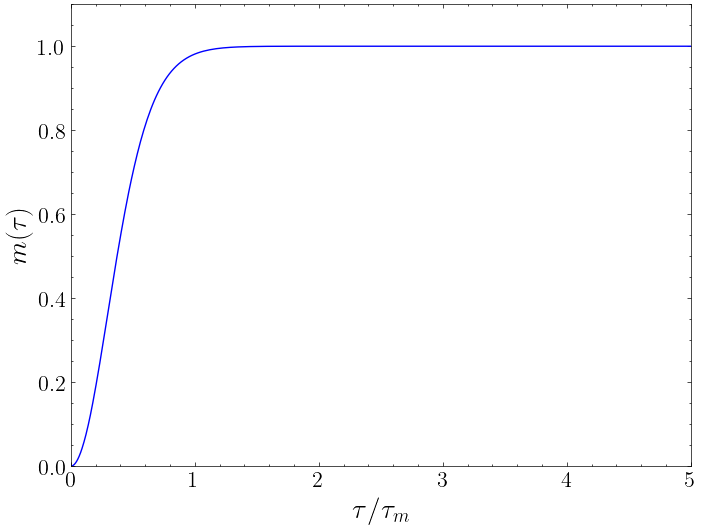

In [3]:
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Data', color='blue')
plt.xlabel(r'$\tau/\tau_{m}$', fontsize = 20)

plt.ylabel(r'$m(\tau)$', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
# plt.xscale('log')
plt.xlim(0,5)
plt.ylim(0,1.1)
plt.show()

In [5]:
def m(mtau,tau_m=1.0): #mtau Pandas DataFrame, tau_m consant
    mtau_cop = mtau.copy()
    mtau_cop.iloc[:,0] = tau_m * mtau_cop.iloc[:,0]
    mtau_interp = interp1d(mtau_cop.iloc[:,0], mtau_cop.iloc[:,1], kind='cubic', fill_value='extrapolate')
    return mtau_interp

def m_prime(m,tau):
    return derivative(m, tau, maxiter=2, order=3)

In [6]:
m_tau_m_1 = m(data,1)

m_prime_m_1 = []
for tau in data.iloc[:,0]:
    m_prime_m_1.append(m_prime(m_tau_m_1, tau).df)

m_prime_m_1 = interp1d(data.iloc[:,0], m_prime_m_1, kind='cubic', fill_value='extrapolate')


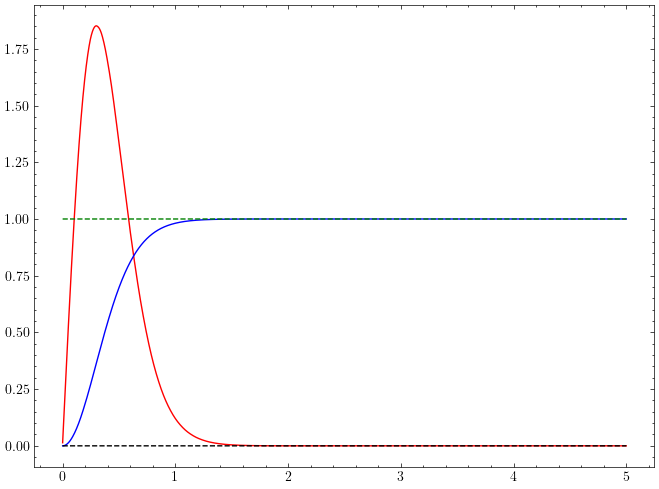

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 5, 10000), m_prime_m_1(np.linspace(0,5,10000)), label=r"$m'(\tau)$", color='red')
plt.plot(np.linspace(0, 5, 10000), m_tau_m_1(np.linspace(0, 5, 10000)), label=r"$m(\tau)$", color='blue')
# plt.xlim(0,1)
plt.plot(np.linspace(0,5,10000), np.ones(10000), color = 'green', linestyle = '--')
plt.plot(np.linspace(0,5,10000), np.zeros(10000), color = 'black', linestyle = '--')
plt.show()

$\rm{cos}(2\phi) = 1\implies\tau={\tau}_{1}$:

/tmp/ipykernel_14395/213925416.py:6: RuntimeWarning: divide by zero encountered in divide
  ((inverse_mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (inverse_mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
/tmp/ipykernel_14395/213925416.py:7: RuntimeWarning: divide by zero encountered in divide
  ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
/tmp/ipykernel_14395/213925416.py:6: RuntimeWarning: invalid value encountered in subtract
  ((inverse_mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (inverse_mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
/tmp/ipykernel_14395/213925416.py:8: RuntimeWarning: divide by zero encountered in divide
  (inverse_mu_r - inverse_mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))


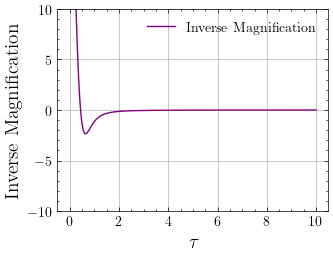

In [12]:
inverse_mu_r = 1 / 3.0
inverse_mu_t = 1 / 100

def inverse_magnification(m,tau):
    return (
        ((inverse_mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (inverse_mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
        ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
        (inverse_mu_r - inverse_mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))
    )

# Generate tau values
tau_values_ex = np.linspace(0,10,100000)

# Compute inverse magnification for each tau
inverse_mag = inverse_magnification(m=m_tau_m_1, tau=tau_values_ex)

# Plot inverse magnification against tau
plt.plot(tau_values_ex, inverse_mag, label='Inverse Magnification', color='purple')
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel('Inverse Magnification', fontsize=14)
plt.ylim(-10,10)
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Function to compute roots for a single tau_m
def compute_roots_for_tau_m(tau_m):
    m_tau_m = m(data, tau_m)
    roots = []
    for i in range(len(tau_values) - 1):
        if np.sign(inverse_magnification(m=m_tau_m, tau=tau_values[i])) != np.sign(inverse_magnification(m=m_tau_m, tau=tau_values[i + 1])):
            # Use root_scalar to find the root in this interval
            inverse_magnification_wrapper = lambda x: inverse_magnification(m_tau_m, x)
            result = root_scalar(inverse_magnification_wrapper, bracket=[tau_values[i], tau_values[i + 1]])
            if result.converged:
                roots.append(result.root)
    return (tau_m, roots)

# Generate tau_m values and tau_values
tau_m_values = np.linspace(0.1, 50, 500)
tau_values = np.linspace(0.001, 50, 10000)

# Parallel computation
with Pool() as pool:
    tau_caustics = pool.map(compute_roots_for_tau_m, tau_m_values)

print(f"Roots found: {tau_caustics}")

Roots found: [(np.float64(0.1), [0.09653410819184222, 0.14874190410450647, 9.999999999999861]), (np.float64(0.2), [9.999999999999861]), (np.float64(0.3), [0.14952521517268513, 9.999999999999863]), (np.float64(0.4), [0.19819721525116424, 9.99999999999986]), (np.float64(0.5), [0.24220838485815324, 9.999999999999861]), (np.float64(0.6), [0.285131271503542, 9.999999999999861]), (np.float64(0.7), [0.32729792368448385, 9.999999999999861]), (np.float64(0.7999999999999999), [0.3683970368237637, 9.999999999999863]), (np.float64(0.8999999999999999), [0.40823065873347464, 9.999999999999863]), (np.float64(0.9999999999999999), [0.4465531073991189, 9.99999999999986]), (np.float64(1.0999999999999999), [0.48306627564513066, 9.999999999999863]), (np.float64(1.2), [0.5175099229365716, 9.999999999999861]), (np.float64(1.3), [0.5500063943307426, 9.999999999999861]), (np.float64(1.4), [0.5804880268328173, 9.999999999999861]), (np.float64(1.5), [0.6089025515624392, 9.999999999999863]), (np.float64(1.5999999

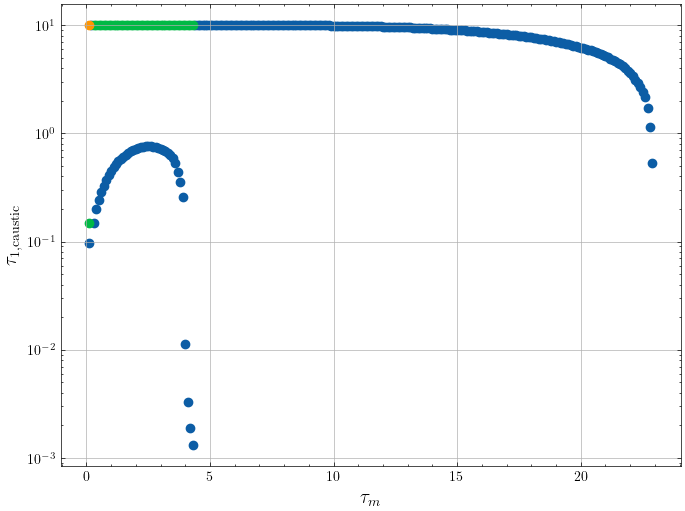

<Figure size 350x262.5 with 0 Axes>

In [77]:
# Extract tau_m and roots from tau_caustics
tau_m_values = [item[0] for item in tau_caustics]  # Extract tau_m values
roots = [item[1] for item in tau_caustics]   # Extract arrays of roots

# Plot each root as a scatter plot
plt.figure(figsize=(8, 6))
for i in range(max(len(r) for r in roots)):  # Iterate over the maximum number of roots
    # Extract the i-th root for all tau_m values (if it exists)
    root_values = [r[i] if i < len(r) else None for r in roots]
    tau_m_filtered = [tau_m_values[j] for j in range(len(root_values)) if root_values[j] is not None]
    root_filtered = [root_values[j] for j in range(len(root_values)) if root_values[j] is not None]
    
    # Plot the i-th root
    plt.scatter(tau_m_filtered, root_filtered, label=f'Root {i+1}')

# Set axis scales and labels
plt.xscale('linear')  # Linear scale for tau_m
plt.yscale('log')     # Log scale for roots
plt.xlabel(r'$\tau_m$', fontsize=14)
plt.ylabel(r'$\tau_{1,\rm{caustic}}$', fontsize=14)
plt.grid(True)
plt.show()

# Save the image as a PNG file
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_caustics.png', dpi=300, format='png')

In [78]:
# Convert tau_caustics to a DataFrame
df = pd.DataFrame(tau_caustics, columns=['tau_m', 'roots'])

# Expand the roots column into separate columns for each root
roots_df = pd.DataFrame(df['roots'].tolist(), index=df.index)

# Rename the columns of roots_df to root_1, root_2, etc.
roots_df.columns = [f'root_{i+1}' for i in range(roots_df.shape[1])]

# Concatenate the tau_m column with the renamed roots DataFrame
df = pd.concat([df.drop(columns=['roots']), roots_df], axis=1)

# Save to a CSV file
df.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_caustics.csv', index=False)

$\rm{cos}(2\phi) = -1\implies\tau={\tau}_{2}$:

/tmp/ipykernel_14395/3658656019.py:3: RuntimeWarning: divide by zero encountered in divide
  ((inverse_mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (inverse_mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
/tmp/ipykernel_14395/3658656019.py:4: RuntimeWarning: divide by zero encountered in divide
  ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 -
/tmp/ipykernel_14395/3658656019.py:3: RuntimeWarning: invalid value encountered in subtract
  ((inverse_mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (inverse_mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
/tmp/ipykernel_14395/3658656019.py:5: RuntimeWarning: divide by zero encountered in divide
  (inverse_mu_r - inverse_mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))


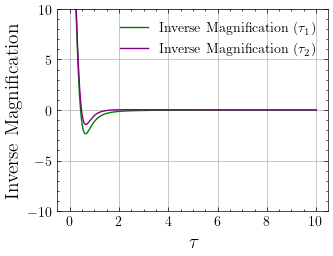

In [19]:
def inverse_magnification_tau_2(m,tau):
    return (
        ((inverse_mu_r - (m_prime(m,tau).df / (2.0 * tau)) ) * (inverse_mu_t - (m_prime(m,tau).df / (2.0 * tau)) )) -
        ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 -
        (inverse_mu_r - inverse_mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))
    )

inverse_mag_tau_2 = inverse_magnification_tau_2(m=m_tau_m_1, tau=tau_values_ex)

# Plot inverse magnification against tau
plt.plot(tau_values_ex, inverse_mag, label=r'Inverse Magnification ($\tau_{1}$)', color='green')
plt.plot(tau_values_ex, inverse_mag_tau_2, label=r'Inverse Magnification ($\tau_{2}$)', color='purple')
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel('Inverse Magnification', fontsize=14)
plt.ylim(-10,10)
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Function to compute roots for a single tau_m
def compute_tau_2_roots_for_tau_m(tau_m):
    m_tau_m = m(data, tau_m)
    roots = []
    for i in range(len(tau_values) - 1):
        if np.sign(inverse_magnification_tau_2(m=m_tau_m, tau=tau_values[i])) != np.sign(inverse_magnification_tau_2(m=m_tau_m, tau=tau_values[i + 1])):
            # Use root_scalar to find the root in this interval
            inverse_magnification_wrapper = lambda x: inverse_magnification_tau_2(m_tau_m, x)
            result = root_scalar(inverse_magnification_wrapper, bracket=[tau_values[i], tau_values[i + 1]])
            if result.converged:
                roots.append(result.root)
    return (tau_m, roots)

# Generate tau_m values and tau_values
tau_m_values = np.linspace(0.1, 50, 500)
tau_values = np.linspace(0.001, 50, 10000)

# Parallel computation
with Pool() as pool:
    tau_caustics = pool.map(compute_tau_2_roots_for_tau_m, tau_m_values)

print(f"Roots found: {tau_caustics}")

Roots found: [(np.float64(0.1), [0.09632530159186575, 0.14915269552292768, 1.732050807568877]), (np.float64(0.2), [1.7320508075688772]), (np.float64(0.3), [0.15222439789812067, 1.7320508075688772]), (np.float64(0.4), [0.201734801525652, 1.732050807568877]), (np.float64(0.5), [0.24789499489020803, 1.7320508075688767]), (np.float64(0.6), [0.29412570570800145, 1.7320508075688772]), (np.float64(0.7), [0.3410176948939715, 1.7320508075689574]), (np.float64(0.7999999999999999), [0.3882210310124136, 1.7320508077257177]), (np.float64(0.8999999999999999), [0.43555213940005466, 1.7320507000381462]), (np.float64(0.9999999999999999), [0.48291580780484267, 1.7320138202684678]), (np.float64(1.0999999999999999), [0.5302709044431246, 1.7318203381165658]), (np.float64(1.2), [0.5779180572069849, 1.7313466562538116]), (np.float64(1.3), [0.62566178484358, 1.730395653983945]), (np.float64(1.4), [0.6733250106179179, 1.728731555415844]), (np.float64(1.5), [0.7209393077823539, 1.7260919939656065]), (np.float64

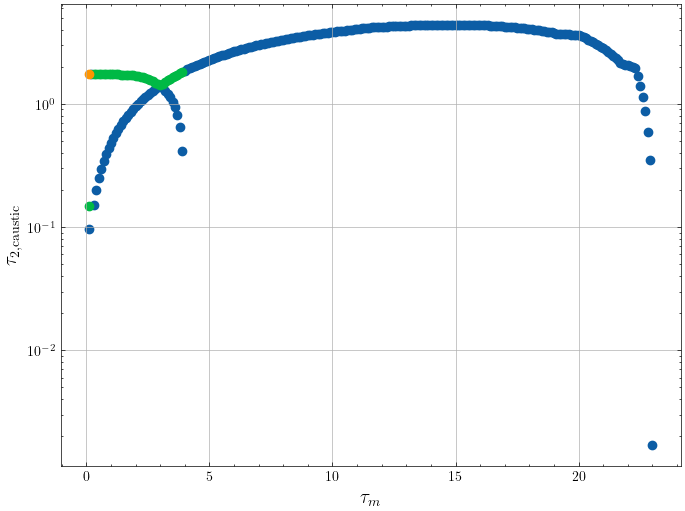

<Figure size 350x262.5 with 0 Axes>

In [22]:
# Extract tau_m and roots from tau_caustics
tau_m_values = [item[0] for item in tau_caustics]  # Extract tau_m values
roots = [item[1] for item in tau_caustics]   # Extract arrays of roots

# Plot each root as a scatter plot
plt.figure(figsize=(8, 6))
for i in range(max(len(r) for r in roots)):  # Iterate over the maximum number of roots
    # Extract the i-th root for all tau_m values (if it exists)
    root_values = [r[i] if i < len(r) else None for r in roots]
    tau_m_filtered = [tau_m_values[j] for j in range(len(root_values)) if root_values[j] is not None]
    root_filtered = [root_values[j] for j in range(len(root_values)) if root_values[j] is not None]
    
    # Plot the i-th root
    plt.scatter(tau_m_filtered, root_filtered, label=f'Root {i+1}')

# Set axis scales and labels
plt.xscale('linear')  # Linear scale for tau_m
plt.yscale('log')     # Log scale for roots
plt.xlabel(r'$\tau_m$', fontsize=14)
plt.ylabel(r'$\tau_{2,\rm{caustic}}$', fontsize=14)
plt.grid(True)
plt.show()

# Save the image as a PNG file
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_caustics_tau_2.png', dpi=300, format='png')

In [23]:
# Convert tau_caustics to a DataFrame
df = pd.DataFrame(tau_caustics, columns=['tau_m', 'roots'])

# Expand the roots column into separate columns for each root
roots_df = pd.DataFrame(df['roots'].tolist(), index=df.index)

# Rename the columns of roots_df to root_1, root_2, etc.
roots_df.columns = [f'root_{i+1}' for i in range(roots_df.shape[1])]

# Concatenate the tau_m column with the renamed roots DataFrame
df = pd.concat([df.drop(columns=['roots']), roots_df], axis=1)

# Save to a CSV file
df.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_caustics_tau_2.csv', index=False)